In [1]:
import pandas as pd
from pathlib import Path

In [2]:
# basics
import os
import time
import numpy as np

# EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
import re
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from concurrent.futures import ProcessPoolExecutor
from sklearn.decomposition import TruncatedSVD

# Model architecture
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV


In [3]:
# Print list of files and directories in folder
list_l = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        list_l.append(os.path.join(dirname, filename))
list_l


['/kaggle/input/test.csv.zip',
 '/kaggle/input/sample_submission.csv',
 '/kaggle/input/train.csv',
 '/kaggle/input/test.csv',
 '/kaggle/input/sample_submission.csv.zip',
 '/kaggle/input/description.md',
 '/kaggle/input/train.csv.zip',
 '/kaggle/input/train.zip',
 '/kaggle/input/spooky-author-identification/test.csv.zip',
 '/kaggle/input/spooky-author-identification/sample_submission.csv',
 '/kaggle/input/spooky-author-identification/train.csv',
 '/kaggle/input/spooky-author-identification/test.csv',
 '/kaggle/input/spooky-author-identification/sample_submission.csv.zip',
 '/kaggle/input/spooky-author-identification/description.md',
 '/kaggle/input/spooky-author-identification/train.csv.zip',
 '/kaggle/input/spooky-author-identification/train.zip']

In [4]:
# Set datasets
train_data = pd.read_csv(list_l[0])
test_data = pd.read_csv(list_l[1])
sample_data = pd.read_csv(list_l[2])


In [5]:
# Cleaning
del list_l


In [6]:
def print_short_summary(name, data):
    """
    Print data head, shape and info.
    Args:
        name (str): name of dataset
        data (dataframe): dataset in a pd.DataFrame format
    """
    print(name)
    print('\n1. Data head:')
    print(data.head())
    print('\n2 Data shape: {}'.format(data.shape))
    print('\n3. Data info:')
    data.info()
    if 'text' in data.columns:
        avg = np.mean(np.vectorize(len)(data['text']))
        print('\n4. Average number of characters per text: {:.0f}'.format(avg))


In [7]:
print_short_summary('Train data', train_data)


Train data

1. Data head:
        id                                               text
0  id27251  There seemed to be a void, and nothing more, a...
1  id09612  This event caused many of those who were about...
2  id11943  I hastily gave my consent to this arrangement,...
3  id19526  It were useless to record the debate that foll...
4  id12931  But how are we to judge of airs, and pronounce...

2 Data shape: (1958, 2)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1958 entries, 0 to 1957
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1958 non-null   object
 1   text    1958 non-null   object
dtypes: object(2)
memory usage: 30.7+ KB

4. Average number of characters per text: 152


In [8]:
print_short_summary('Test data', test_data)


Test data

1. Data head:
        id       EAP       HPL       MWS
0  id27251  0.403494  0.287808  0.308698
1  id09612  0.403494  0.287808  0.308698
2  id11943  0.403494  0.287808  0.308698
3  id19526  0.403494  0.287808  0.308698
4  id12931  0.403494  0.287808  0.308698

2 Data shape: (1958, 4)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1958 entries, 0 to 1957
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1958 non-null   object 
 1   EAP     1958 non-null   float64
 2   HPL     1958 non-null   float64
 3   MWS     1958 non-null   float64
dtypes: float64(3), object(1)
memory usage: 61.3+ KB


In [9]:
print_short_summary('Sample data', sample_data)


Sample data

1. Data head:
        id                                               text author
0  id06121  So I did not abandon the search until I had be...    EAP
1  id01074  He had promised to spend some hours with me on...    MWS
2  id12145  In the end he give him a funny kind o' thingum...    HPL
3  id18286  What other construction could I possibly put u...    EAP
4  id11118  I had heard the noise, however faint, and my s...    EAP

2 Data shape: (17621, 3)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17621 entries, 0 to 17620
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17621 non-null  object
 1   text    17621 non-null  object
 2   author  17621 non-null  object
dtypes: object(3)
memory usage: 413.1+ KB

4. Average number of characters per text: 149


In [10]:
# Cleaning
del print_short_summary


In [11]:
# Plot horizontal barplot of number of records per label
plt.figure(figsize=(16, 9))
tmp = train_data['author'].value_counts()
sns.barplot(y=tmp.index.values, x=tmp.values, orient='h')
plt.xlabel('Number of records')
plt.ylabel('Author')
plt.title('Number of records per author')
plt.show()


KeyError: 'author'

<Figure size 1600x900 with 0 Axes>

In [12]:
# Cleaning
del tmp


NameError: name 'tmp' is not defined

In [13]:
def plot_word_dist_author(labels, top_n_words = 10):
    """
    Plot charts with word frequencies per author
    Args:
        labels: list of authors
        top_n_words (opt): how many top words to plot in one chart
    """
    n = len(labels)
    
    # Get default seaborn's palette to match colours with the previous chart
    default_palette = sns.color_palette("deep")
    
    # Initialize subplots with 1 row and n columns
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(16, 9))
    
    # Plot word count per author in the respective rows
    for i in range(n):
        col = i % n
        indexes = train_data['author'] == labels[i]
        w = train_data['text'][indexes].str.split(expand=True).unstack().value_counts()
        l = w[:top_n_words]/np.sum(w)*100
        axes[col].bar(l.index, l.values, color=default_palette[i])
        axes[col].set_title(labels[i])
        axes[col].set_xlabel('Words')
        axes[col].set_ylabel('Percentage of total word count (%)')

    plt.tight_layout()
    plt.show()


KeyError: 'author'

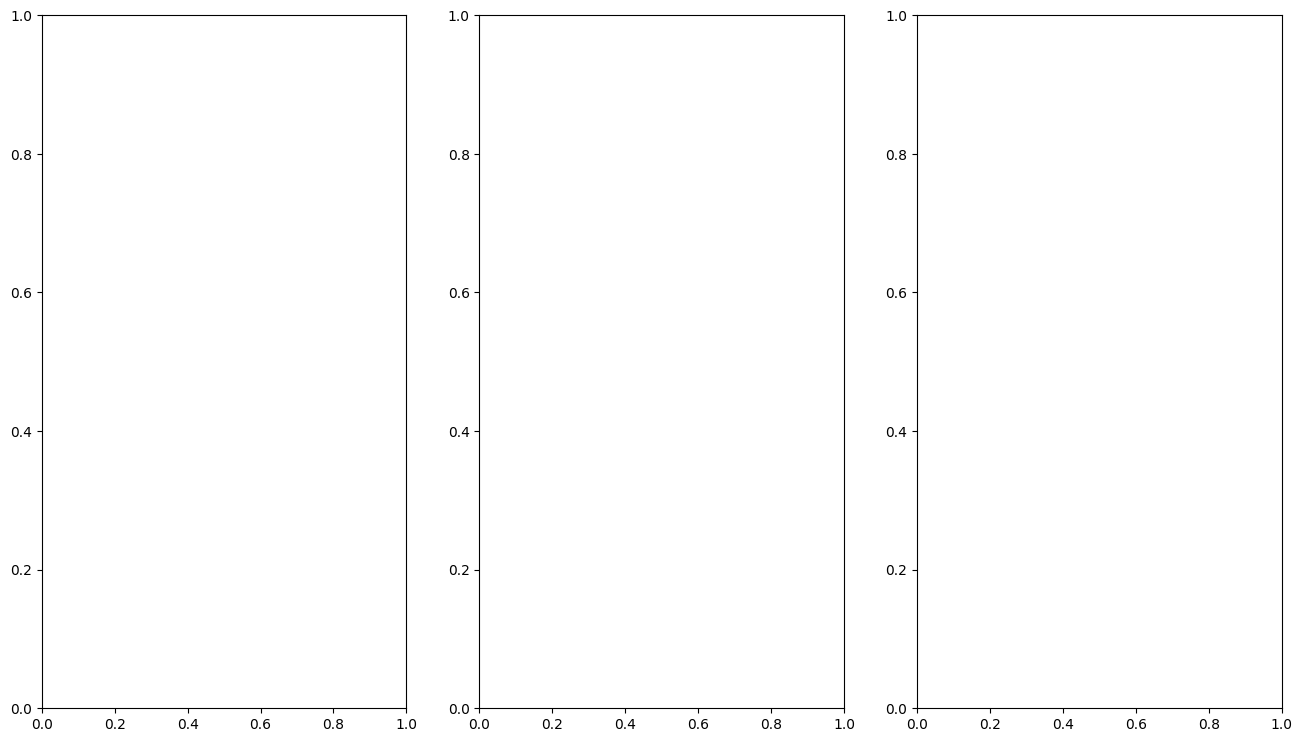

In [14]:
# Plot word frequencies by author
plot_word_dist_author(['EAP', 'MWS', 'HPL'])


In [15]:
# Cleaning
del plot_word_dist_author


In [16]:
# Load english lemmas
spacy_process = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Compile regex pattern
pattern = re.compile(r'\b([a-zA-Z])\b|\d+|[.,!?()-:;]')

# Set english stopwords such as "the", "of", "and", "to" etc.
stop_words = set(stopwords.words('english'))


In [17]:
def get_processed_text(text):
    """
    Return lemmatized text without single letters and digits.
    Everything is in the lower case register.
    Args:
        text (str): text of an article
    Returns:
        text (str): cleand text
    """
    # Convert to lowercase and remove digits, single letters
    text = pattern.sub('', text.lower())
    
    # Get lemma tokens
    lemmas = spacy_process(text)
    lemmas = [token.lemma_ for token in lemmas if token.text not in stop_words]

    # Join the words back into a string
    text = ' '.join(lemmas)
    
    return text

def get_clean_text(texts):
    """
    Return cleaned text.
    Execution in parallel.
    
    Args:
        texts: numpy array of string elements
    Returns:
        clean_texts: numpy array of cleaned string elements
    """
    # Set up parallel tasks processing 
    with ProcessPoolExecutor() as executor:
        clean_texts = list(executor.map(get_processed_text, texts))
        
    return np.array(clean_texts)


In [18]:
# Get cleaned train and test texts
train_clean_data = get_clean_text(train_data['text'].values)
test_clean_data = get_clean_text(test_data['text'].values)


KeyError: 'text'

In [19]:
# Print an example of the cleaned text
train_clean_data[0]


'seem   void nothing   feel   childish fear prompt draw hip pocket revolver   always carry dark since night   hold east providence'

In [20]:
# Cleaning
del spacy_process, pattern, stop_words
del get_clean_text, get_processed_text


In [21]:
# Create vectorizer to convert plain text into feature matrix
vectorizer = TfidfVectorizer(sublinear_tf = True
                             , ngram_range = (1,2)
                             )
tfidf_vect = vectorizer.fit(train_clean_data)


In [22]:
# Set training and testing data for the upcoming models
X_train_tfidf = tfidf_vect.transform(train_clean_data)
X_test_tfidf = tfidf_vect.transform(test_clean_data)


NameError: name 'test_clean_data' is not defined

In [23]:
del vectorizer, test_data, train_clean_data, test_clean_data


NameError: name 'test_clean_data' is not defined

In [24]:
# Reduce dimensionality of TF-IDF matrices
svd = TruncatedSVD(n_components=100)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)


NameError: name 'X_test_tfidf' is not defined

In [25]:
# Standardize features without centering
scaler = StandardScaler(with_mean = False)
X_train_stand = scaler.fit_transform(X_train_tfidf)
X_test_stand = scaler.fit_transform(X_test_tfidf)

X_train_stand_svd = scaler.fit_transform(X_train_svd)
X_test_stand_svd = scaler.fit_transform(X_test_svd)


NameError: name 'X_test_tfidf' is not defined

In [26]:
# Cleaning
del scaler


In [27]:
# Encode labels using OneHotEncoder
dict_map = {'EAP':0, 'MWS':1, 'HPL':2,}
y_train = train_data['author'].map(dict_map).values


KeyError: 'author'

In [28]:
# Cleaning
del label_encoder, train_data


NameError: name 'label_encoder' is not defined

In [29]:
# Set config for GridSearchCV
config_logreg = {
    'model': LogisticRegression()
    , 'name': 'Log Reg'
    , 'param_grid':
    {
        'class_weight': ['balanced']
        , 'C': [0.5, 1.0, 1.5]
        , 'solver': ['saga', 'lbfgs']
    }
}


In [30]:
# Set config for GridSearchCV
config_rf = {
    'model': RandomForestClassifier()
    , 'name': 'Random Forest'
    , 'param_grid':
    {
        'n_estimators': [50, 75, 100]
        , 'max_depth': [10, 20]
    }
}


In [31]:
# Set config for GridSearchCV
config_nb = {
    'model': MultinomialNB()
    , 'name': 'Mult NB'
    , 'param_grid':
    {
        'alpha': [0.001, 0.01, 0.1, 0.2, 0.4]
    }
}


In [32]:
# Set config for GridSearchCV
config_svm = {
    'model': SVC()
    , 'name': 'SVM'
    , 'param_grid':
    {
        'class_weight': ['balanced']
        , 'probability': [True]
        , 'max_iter': [100]
        , 'C': [0.5, 1.0, 1.5]
        , 'kernel': ['rbf', 'sigmoid']
    }
}


In [33]:
# Set config for GridSearchCV
config_xgb = {
    'model': xgb.XGBClassifier()
    , 'name': 'XGBoost'
    , 'param_grid':
    {
        'objective': ['multi:softmax']
        , 'num_class': [3]
        , 'eval_metric': ['mlogloss']
        , 'n_estimators': [100]
        , 'eta': [0.2, 0.3, 0.4]
        , 'max_depth': [5, 7]
    }
}


In [34]:
def get_grid(config_model, X_train, y_train):
    """
    Return grid of GridSearchCV results from selected models and their parameters.
    Execution in parallel.
    
    Args:
        config_model (dict): dictionary of model's parameters
        X_train (ndarray): data to train
        y_train (ndarray): data labels
    Returns:
        dict: a dictionary with the results from training via GridSeachCV
    """
    # GridSearchCV utilizes all available CPU cores with n_jobs = -1.
    grid = GridSearchCV(config_model['model']
                        , config_model['param_grid']
                        , return_train_score = True
                        , scoring = 'neg_log_loss'
                        , cv = 5
                        , n_jobs = -1)

    # Fit object to training data
    grid = grid.fit(X_train, y_train)
        

    return grid


def get_model_results(model_name, grid_results, data_standardized):
    """
    Return a dictionary of model results.
    
    Args:
        model_name (str): name of a model
        grid_results (dict): GridSearchCV dictionary of model results
        data_standardized (1 or 0): data is stadardized
    Returns:
        dict: dictionary with updated columns
    """
    runtime = grid_results['mean_fit_time'] + grid_results['mean_score_time']
    model_results = {
        'model': model_name
        , 'params': grid_results['params']
        , 'data_std': data_standardized
        , 'mean_runtime (sec)': runtime
        , 'mean_train_score (logloss)': -grid_results['mean_train_score']
        , 'mean_test_score (logloss)': -grid_results['mean_test_score']
    }
    
    return model_results

def get_table_results_sorted(list_dict):
    """
    Convert list of dictionaries and sort by mean_test_score and mean_runtime.
    
    Args:
        list_dict (list): list of dictionaries from GridSearchCV
    Returns:
        DataFrame: sorted dataframe by mean_test_score and mean_runtime
    """
    table = [pd.DataFrame(results) for results in list_dict]   
    table = pd.concat(table)
    table = table.sort_values(by = ['mean_test_score (logloss)'
                                  ,'mean_runtime (sec)']
                        , ascending = [True, True])
    
    return table

def get_final_table_results(config_models, config_data):
    """
    Return table with every trained model and its results from GridSearchCV.
    
    Args:
        config_models (list): list of model configurations
        confg_data (list): list of data configurations
    Returns:
        DataFrame: sorted dataframe by mean_test_score and mean_runtime
    """
    n = len(config_models)
    m = len(config_data)
    table = []
    for i in range(n):
        for j in range(m):
            print('model: {} of {} | data: {} of {}'.format(i+1,n,j+1,m))
            grid = get_grid(config_models[i], config_data[j], y_train)
            model_results = get_model_results(config_models[i]['name']
                                              , grid.cv_results_
                                             , j)
            table.append(model_results)
    
    table = get_table_results_sorted(table)

    return table


In [35]:
# Create table of Multinomial Naive Bayes results
table_nb = get_final_table_results([config_nb], [X_train_tfidf, X_train_stand])


model: 1 of 1 | data: 1 of 2


NameError: name 'y_train' is not defined

In [36]:
# Set list of models except Mult NB and non/standardized X_train
config_models = [config_logreg, config_rf, config_svm, config_xgb]
config_data = [X_train_svd, X_train_stand_svd]


NameError: name 'X_train_stand_svd' is not defined

In [37]:
# Get table of every model except Mult NB
table_results = get_final_table_results(config_models, config_data)


NameError: name 'config_data' is not defined

In [38]:
# Concatenate tables and print final rankings
table_results = get_table_results_sorted([table_results, table_nb])
table_results


NameError: name 'table_results' is not defined

In [39]:
# Cleaning
del config_models, config_data, table_results
del get_results_table, get_grid, get_final_table_results


NameError: name 'config_data' is not defined

In [40]:
# Fit top performance model
model = MultinomialNB(alpha = 0.01).fit(X_train_tfidf, y_train)


NameError: name 'y_train' is not defined

In [41]:
# Get predicted probabilities of classes
results = model.predict_proba(X_test_tfidf)


NameError: name 'model' is not defined

In [42]:
# Create submission talbe
table_submis = pd.DataFrame(results, columns=['EAP', 'MWS', 'HPL'])
table_submis['id'] = sample_data['id']


NameError: name 'results' is not defined

In [43]:
# Print submission table
table_submis


NameError: name 'table_submis' is not defined

In [44]:
# Make submission
table_submis.to_csv('submission.csv', index=False)


NameError: name 'table_submis' is not defined

In [45]:
# Cleaning
del sample_data
